<h6> Solution created by Shay Halfon </h6>

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore", category=RuntimeWarning)
from abc import ABC, abstractmethod

## learning modules
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from sklearn.model_selection import cross_val_score

## modules for plotting
from scipy import misc
from sklearn.externals.six import StringIO
#from sklearn.tree import export_graphviz
#import pydotplus

In [2]:
#plots
def plot_roc_curve(fpr, tpr, title, file_image_name):
    '''
        Generates a roc curve and saves it to dics
        :param fpr: list of fpr values
        :param tpr: list of tpr values
        :param title: model by which the ROC curve was produced
        :param file_image_name: output file name
    '''
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - ' + title)
    plt.legend()

    id, fname = 0, file_image_name
    while os.path.isfile(fname):
        fname = file_image_name + '_' + str(id) + '.png'
        id += 1
    plt.savefig(fname)
    plt.close()


def decision_tree_plotter(dtree, feature_names_, output_path):
    '''
        Generates a roc curve and saves it to dics
        ## IMPORTANT NOTE:
        ## using pydotplus to create a visualization
        ## requires: pip install pydotplus;
        ## if installation fails, try to run the following command: conda install -c anaconda html5lib
        ## graphviz must be installed over the machine: https://graphviz.gitlab.io/download/
        :param dtree: trained decision tree to plot
        :param feature_names_: names of explaining variables
        :param output_path: output file name
    '''
    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data, filled=True, rounded=True,
                    special_characters=True, feature_names=feature_names_)
    pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png('decision_tree.png')
    img = misc.imread(output_path)
    plt.rcParams["figure.figsize"] = (20, 20)
    plt.imshow(img)

In [3]:
class CorrelationsComputer:

    @staticmethod
    def find_pairs_with_correlation_above(df, columns, threshold):
        '''
            :param df: dataframe rows are deals, columns are property characteristics 
            :param columns: subset of the numerical columns in the df
            :return: list of tuples: [(attr_name, attr_name, correlation)] of pairs of columns with absolute correlation above threshold
        '''
        correlation_matrix = df.corr().round(5)
        c = correlation_matrix.stack().drop_duplicates().reset_index().values
        tp = [tuple(x) for x in c if abs(x[2]) >= threshold and abs(x[2])!=1]
        return tp

    @staticmethod
    def choose_predictive_attributes(df, columns, target, exclusive_features, n=10):
        '''
            The function chooses n attributes, which are the most correlated with
            target and do not appear in the 'exclusive_features' pairs
            :param df: dataframe
            :param columns : subset of the numerical columns in df
            :param target: label to predict by
            :param exclusive_features: a list of attributes which cannot appear together
            :return: list of column names
        '''
        correlation_matrix = df[columns].corr().round(5)
        
        s = abs(correlation_matrix['SalePrice']).sort_values(ascending = False)
        dic = {key:value for key,value,x in exclusive_features}
        dic2 = {value:key for key,value,x in exclusive_features}
        dic.update(dic2)
        copy = list(s.index)
        
        for x in copy:
            if x in dic.keys():
                copy.remove(dic[x])

        return copy[1:n+1]

In [4]:
class DataManager:

    def __init__(self, input_file):
        '''
            :param input_file: csv file
            ## read file content into self.df dataframe 
        '''
        self.input_file = input_file
        '''
        df.index = df['Id']
        df = df.drop(['Id'], axis =1)
        '''
        df = pd.read_csv(self.input_file)
        self.df = df

    def get_numerical_columns(self):
        '''
            The function returns a list of names of all numerical columns in self.df
            :return: a list with columns names that correspond to columns with numerical data;
            ## Guidance: you may use: np.issubdtype(self.df[col].dtype, np.number) to check if a column is numeric
        '''
        return [x for x in self.df.columns if np.issubdtype(self.df[x],np.number)]

    def summarize_non_numeric_attribute(self):
        '''
            The function returns a dictionary of the unique categories in each of the non-numeric columns
            :param self.df: pd.Dataframe in format_1
            :return: dict: non-numeric col => set() of values in df[non-numeric col]
            ## Guidance: consider using the get_numerical_columns method
        '''
        ls =  [x for x in self.df.columns if x not in self.get_numerical_columns()]
        dic = {key:set(self.df[key]) for key in ls}
        #dic = {key:set(self.df[key].unique()) for key in ls}
        return dic

    def select_and_dropna(self, columns):
        '''
            :param df: dataframe
            :param columns: columns to keep
            :return: a subset of the dataframe that includes only the specified columns. 
            :the function drops rows that include 'na' values in one of the specified columns
        '''
        df = self.df[columns].dropna(axis = 0)
        return df

    def transform_numerical_attribute_to_boolean(self, df, col, new_col_name, quantile=0.9):
        '''
            The function returns a copied dataframe with additional column, new_col_name.
            the 'new_col_name' contains a mask of 'col' values, 
            such that any value of 'col' larger than the quantile (of col) is assigned to 1, 
            and all others are assigned to 0.
            :param df: dataframe
            :param col: numeric column to transform
            :param new_col_name: new column name
            :param quantile:  quantile over requested column;
            :return: new df with 'new_col_name' added column
            ## Hint: consider pandas.DataFrame.quantile, to get the value of the quantile of 'col';
            ## then convert boolean values to 0 and 1 using pandas.DataFrame.apply(func=lambda x: 1 if x else 0)
            ## Important note: Do not change the original data frame
        '''
        df = df.copy()
        q = df[col].quantile(quantile)
        df[new_col_name] = [1 if (x>=q) else 0 for x in df[col]]
        return df

    def plot_dist(self, col):
        '''
            this function plots the distribution of a numerical variable 'col'
            :param col: name of numerical column in the dataframe
            :return:
            ## Guidance: Use:
            ## sns.set(rc={'figure.figsize': (12, 8)}); sns.distplot;
            ## then display figure using plt.show(); 
            ## consider adding 'col' title using plt.title
        '''
        sns.set(rc={'figure.figsize': (12, 8)})
        sns.distplot(self.df[col], bins=30)
        plt.title(col)
        return

In [5]:
class Learner(ABC):

    def __init__(self, df, target):
        '''
            The function obtains a dataframe and a target column;
            1. stores the target column in self.target;
            2. stores the target all other columns in self.data (i.e., it remove target column from df);
            3. initializes a model field
            :param df: pd.Dataframe
            :param target: name of target column
        '''
        df = df.copy()
        self.target = df[target] 
        self.data = df.drop(columns =[target])  # drop(target, axis=1)
        self.model = None ## Leave this as is, will be filled by sub-classes

    def train_model(self, test_ratio=0.2, columns_to_predict_by= None):
        '''
            The method selects the columns_to_predict_by from self.data.
            Then, it initializes self.X_train, self.X_test, self.Y_train, self.Y_test,
            which are produced using sklearn.model_selection.train_test_split;
            :param test_ratio: portion of the data that should be used for testing
            :param columns_to_predict_by: columns to predict by; if None, all columns in self.df are used
            :return: None
        '''
        if columns_to_predict_by is None:
            columns_to_predict_by = self.data.columns
        self.X_train, self.X_test, self.Y_train, self.Y_test = \
            train_test_split(self.data[columns_to_predict_by], self.target, test_size=test_ratio, random_state=5)

    def get_model_scores(self, train=False):
        '''
            The function reports the last trained model scores over the train or test set
            Implemnted by sub-classes
            :param train: (boolean - if True predict using train, otherwise use the self.test set)
            :return:
        '''
        raise NotImplemented('get_model_scores is only implemented by sub-class')

    def output_model_summary(self):
        '''
            The function outputs a summary of the last trained model
            Implemnted by sub-classes
            :param train:
            :return:
        '''
        raise NotImplemented('output_model_summary is only implemented by sub-class')

In [6]:
class RegressionLearner(Learner, ABC):

    def __init__(self, df, target):
        '''
            The function obtains a dataframe and a target column;
            1. stores the target column in self.target;
            2. stores the target all other columns in self.data (i.e., it remove target column from df);
            3. initializes a model field
            :param df: pd.Dataframe
            :param target: name of target column
        '''
        Learner.__init__(self, df, target)

    def train_model(self, func, test_ratio=0.2, columns_to_predict_by= None, **args):
        '''
            The function calls the Learner.train method in order
            to select the columns to predict and split
            the data to train and test.
            It adds a constant 1 to self.X_train, and self.X_test.
            Then it fits a regression model using the
            provided learning method 'func' over self.X_train, self.Y_train.
            If the fit function requires parameters, they are provided using **args.
            The resulting model is stored in the self.model attribute
            :param columns_to_predict_by : columns to predict by
            :param test_ratio: proportions of observations to use for testing;
            :param args: additional named attributes: e.g., method='bfgs', maxiter=100
            :return: None
            ## Important note: use sm.add_constant(X) to assign the self.X_train and self.X_test
            before you call the 'func' and the fit methods;
        '''
        '''
        this creates the train/test sets and we grab them by self
        '''
        Learner.train_model(self, test_ratio, columns_to_predict_by)
        self.X_train = sm.add_constant(self.X_train)
        self.X_test = sm.add_constant(self.X_test)
        
        self.model = func(self.Y_train,self.X_train)
        self.model = self.model.fit(**args)

    def get_model_scores(self, score_method, train=False):
        '''
            The function reports the trained model scores (AIC&BIC) over the train or test set
            :return: dict: {score_attribute: score_result}
        '''
        X = self.X_train if train else self.X_test
        Y_actual = self.Y_train if train else self.Y_test
        Y_predicted = self.model.predict(X)
        return {str(score_method.__name__): score_method(Y_actual, Y_predicted), 'aic': self.model.aic, 'bic': self.model.bic}

    def output_model_summary(self):
        '''
            prints the output of the regression model
            :return: None
        '''
        print(self.model.summary())

    def find_significant_attributes(self, alpha=.05):
        '''
            The function iterates over the coefficients in the trained regression model,
            and returns the ones that are significant for the provided 
            significance value alpha.
            :param alpha: significant value
            :return: a list of all statistically significant coefficients
            sorted by their p_value (in ascending order);
            IMPORTANT REMARK: The 'const' field is removed.
            ## Guidance: use pd.concat() to join the self.model.params and
            self.model.pvalues
            ## then sort the result dataframe by the pvalues 
            using pd.DataFrame.sort_values
            ## finally using masking select the attributes that are statistically significant (i.e., <0.05)
            ## don't forget to remove the constant field
        '''
        ls = [self.model.params,self.model.pvalues]
        dt = pd.concat(ls, axis=1)
        dt.drop(index = ['const'], inplace=True)
        pvs = dt[dt.sort_values(by=[1], ascending=True)[1] <alpha]
        
        return pvs.index

    def print_effects(self, message, func=None):
        '''
            The function applies 'func' over the coefficients of the last trained model
            :param: a message to be printed describing the effects
            :param func: function from number => number
            :return: None
        '''
        if func == None:
            func = lambda x: x
        print(message, func(self.model.params))

In [7]:
class LinearRegressionLearner(RegressionLearner):

    def __init__(self, df, target):
        '''
            The function calls the RegressionLearner.train_model method
            with the parameters that would train a linear regression model.
            :param columns_to_predict_by : columns to predict by
            :param test_ratio: proportions of observations to use for testing;
            :return: None
        '''
        RegressionLearner.__init__(self, df, target)
        self.name = 'linear regression'

    def train_model(self, test_ratio=0.2, columns_to_predict_by = None):
        '''
            The function calls the RegressionLearner.train_model method
            with the parameters that would train a linear regression model.
            :param columns_to_predict_by : columns to predict by
            :param test_ratio: proportions of observations to use for testing;
            :param args: additional named attributes: e.g., method='bfgs', maxiter=100
            :return: None
        '''
        RegressionLearner.train_model(self,sm.OLS, test_ratio, columns_to_predict_by )
        

    def get_model_scores(self, train=False):
        ''' SEE IMPORTANT NOTE IN test_ratio
            The function reports R^2 of the last trained model scores over the train or test set
            :return: dict: {score_attribute: score_result}
        '''
        return RegressionLearner.get_model_scores(self,r2_score)
        pass  ## TODO: fill in the missing code; Use: RegressionLearner.get_model_scores

    def print_effects(self):
        RegressionLearner.print_effects(self, "", None) ## TODO replace None with the message

In [8]:
class LogisticRegressionLearner(RegressionLearner):

    def __init__(self, df, target):
        '''
            The function calls the RegressionLearner.train_model method
            with the parameters that would train a logistic regression model.
            It sends method='bfgs', maxiter=100 as addional paramters to fit
            :param columns_to_predict_by : columns to predict by
            :param test_ratio: proportions of observations to use for testing;
            :return: None
        '''
        RegressionLearner.__init__(self, df, target)
        self.name = 'logistic_regression'

    def train_model(self, test_ratio=0.2, columns_to_predict_by = None):
        '''
            The function calls the RegressionLearner.train_model method
            with the parameters that would train a logistic regression model.
            It sends method='bfgs', maxiter=100 as addional paramters to fit
            :param columns_to_predict_by : columns to predict by
            :param test_ratio: proportions of observations to use for testing;
            :param args: additional named attributes: e.g., method='bfgs', maxiter=100
            :return: None
        '''
        RegressionLearner.train_model(self,sm.Logit, test_ratio, columns_to_predict_by,method='bfgs', maxiter=100 )

    def get_model_scores(self, train=False):
        ''' SEE IMPORTANT NOTE IN test_ratio
            The function reports roc_auc_score of the last
            trained model scores over the train or test set
            :return: dict: {score_attribute: score_result}
            ## Guidance: use from sklearn.metrics import roc_curve, roc_auc_score
            
        '''
        return RegressionLearner.get_model_scores(self,roc_auc_score)
  


    def print_effects(self):
        '''
            The function applies np.exp over the coefficients of the last trained model
            :return: None
        '''
        RegressionLearner.print_effects(self,
                                        "",
                                        np.exp) ## TODO: add message and send the right function s

    def output_model_summary(self, output_path='LR_roc_curve.png'):
        '''
        The function outputs the regression model summary;
        Furthermore, it saves a roc_curve figure of the results to disc
        :param output_path:
        :return:
        '''
        RegressionLearner.output_model_summary(self)
        ## TODO: use from sklearn.metrics import roc_curve and the
        #helper function 'plot_roc_curve' to create a roc curve
        fpr, tpr, thresholds = roc_curve(self.Y_test,self.model.predict(self.X_test))
        
        plot_roc_curve(fpr,tpr,'roc',output_path)

In [9]:
class DTLearner(Learner):

    def __init__(self, df, target):
        '''
            The function obtains a dataframe and a target column;
            1. stores the target column in self.target;
            2. stores the target all other columns in self.data (i.e., it remove target column from df);
            3. initializes a model field
            The function mustn't change df
            :param df: pd.Dataframe
            :param target: name of target column
        '''
        Learner.__init__(self, df, target)
        self.name = 'decision_tree'

    def train_model(self, test_ratio=0.2, columns_to_predict_by=None):
        '''
            The function calls the Learner.train method in order to select the columns to predict and split
            the data to train and test.
            Then it fits a decision tree model using the 
            provided setting max_depth=5, min_samples_split=5.
            If the fit the tree over the train data.
            The resulting model is stored in the self.model attribute
            :param columns_to_predict_by : columns to predict by
            :param test_ratio: proportions of observations to use for testing;
            :return: None
            ## Guidance: use DecisionTreeClassifier;
        '''
        Learner.train_model(self, test_ratio, columns_to_predict_by)
        dtree = DecisionTreeClassifier(max_depth=5, min_samples_split=5)
        self.model = dtree.fit(self.X_train, self.Y_train)

    def get_model_scores(self, train=False):
        '''
            The function reports the last trained decision tree model score over the train or test set
            :return: dict: {score_attribute: score_result}
            Guidance: use the score method of the decision tree model
        '''
        X = self.X_train if train else self.X_test
        Y_actual = self.Y_train if train else self.Y_test
        return {'DT score:': self.model.score(X,Y_actual)} ## TODO: replace None with score

    def output_model_summary(self, cv_=10, output_path='decision_tree.png'):
        '''
            The function outputs the mean cross validation score of the last trained DT model.
            and outputs the tree to output_path
            :param output_path:
            :return: None
            Guidance: use sklearn.model_selection.cross_val_score, use np.mean to compute the mean
        '''
        print('mean cross validation score', np.mean(cross_val_score(self.model, self.X_test, self.Y_test, cv=cv_)))
        print('Decision tree printed to file', output_path)
        #decision_tree_plotter(None, None, None) ## TODO: complete function parameters


Total neighborhoods 25
Total of 38 numerical attributes


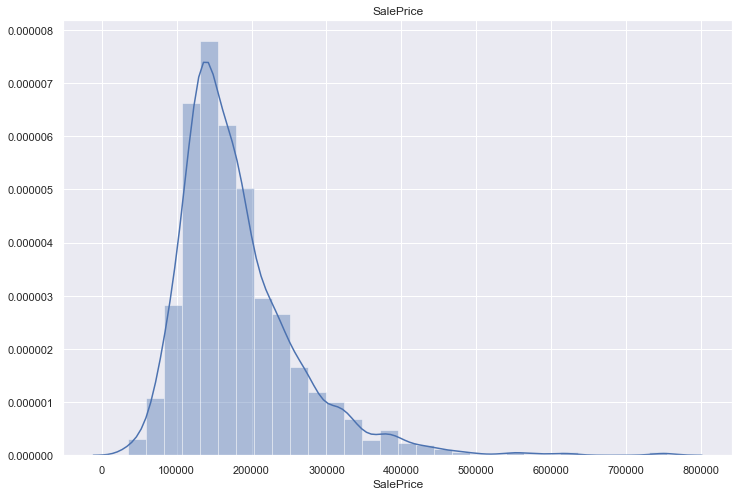

In [10]:
#if __name__ == '__main__':

## part A: data exploration
input_file = 'data.csv'
target = 'SalePrice'
high_correlation_level = 0.8
data_manager = DataManager(input_file)
print('Total neighborhoods', len(data_manager.summarize_non_numeric_attribute()['Neighborhood']))
print('Total of', len(data_manager.get_numerical_columns()), 'numerical attributes')
numerical_columns = data_manager.get_numerical_columns()
data_manager.plot_dist(target)

In [11]:
## part B: correlations: features selection
CC = CorrelationsComputer()
exclusive_pairs = CC.find_pairs_with_correlation_above(data_manager.df, numerical_columns, high_correlation_level)
print("Pairs with correlation above", str(high_correlation_level) + ":")
for x in sorted(exclusive_pairs, key=lambda x: x, reverse=True): print(x)

candidate_attributes = CC.choose_predictive_attributes(data_manager.df, numerical_columns, target, exclusive_pairs, 10)
print('Candidate attributes for prediction:', candidate_attributes)
chosen_columns = candidate_attributes.copy()
chosen_columns.append(target)
df = data_manager.select_and_dropna(chosen_columns)

Pairs with correlation above 0.8:
('YearBuilt', 'GarageYrBlt', 0.82567)
('TotalBsmtSF', '1stFlrSF', 0.81953)
('GrLivArea', 'TotRmsAbvGrd', 0.82549)
('GarageCars', 'GarageArea', 0.88248)
Candidate attributes for prediction: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1']


In [12]:
## part C: run learners
linear_learner = LinearRegressionLearner(df, target)
expensive_house_column = 'LuxuryApartment'
df_with_larger_class = data_manager.transform_numerical_attribute_to_boolean(df, target, expensive_house_column, quantile=0.9)
df_with_larger_class = df_with_larger_class.drop(target, axis=1)
logistic_learner = LogisticRegressionLearner(df_with_larger_class, expensive_house_column)
dtree_learner = DTLearner(df_with_larger_class, expensive_house_column)
learners = [linear_learner, logistic_learner, dtree_learner]


for learner in learners:

    print('####################',learner.name,'####################')
    learner.train_model()
    print('Full Model scores:')
    for score, result in learner.get_model_scores(False).items(): print(score, result)
    print('Full Model Summary:')
    learner.output_model_summary()

    if hasattr(learner, 'find_significant_attributes'):
        significant_attributes = learner.find_significant_attributes(alpha=0.05)
        print('Significant attributes by', learner.name, ':', significant_attributes)
        print('--------------', 'results with only significant attributes', ' -------------')
        learner.train_model(columns_to_predict_by = significant_attributes)
        print('Small model score:', learner.get_model_scores(False))
        for score, result in learner.get_model_scores(False).items(): print(score, result)
        print('Small Model Summary:')
        learner.output_model_summary()
        learner.print_effects()

#################### linear regression ####################
Full Model scores:
r2_score 0.619718747012147
aic 27501.935436069827
bic 27557.562842868505
Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     526.8
Date:                Sat, 10 Aug 2019   Prob (F-statistic):               0.00
Time:                        13:39:13   Log-Likelihood:                -13740.
No. Observations:                1161   AIC:                         2.750e+04
Df Residuals:                    1150   BIC:                         2.756e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err    

C:\Users\shayh\python\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\shayh\python\lib\site-packages\ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\shayh\python\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\shayh\python\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Significant attributes by logistic_regression : Index(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearRemodAdd',
       'Fireplaces', 'BsmtFinSF1'],
      dtype='object')
-------------- results with only significant attributes  -------------
Optimization terminated successfully.

C:\Users\shayh\python\lib\site-packages\ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\shayh\python\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)



         Current function value: 0.084261
         Iterations: 71
         Function evaluations: 85
         Gradient evaluations: 78
Small model score: {'roc_auc_score': 0.9819015444015444, 'aic': 211.65352680840283, 'bic': 252.10982266198596}
roc_auc_score 0.9819015444015444
aic 211.65352680840283
bic 252.10982266198596
Small Model Summary:
                           Logit Regression Results                           
Dep. Variable:        LuxuryApartment   No. Observations:                 1161
Model:                          Logit   Df Residuals:                     1153
Method:                           MLE   Df Model:                            7
Date:                Sat, 10 Aug 2019   Pseudo R-squ.:                  0.7376
Time:                        13:39:14   Log-Likelihood:                -97.827
converged:                       True   LL-Null:                       -372.79
                                        LLR p-value:                1.470e-114
                   coe